In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import signal
from mi_estimators import *
import sklearn.preprocessing as sklp
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

torch.cuda.empty_cache()

cuda


In [2]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    #plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [114]:
class ConvolutionSampler(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same', padding_mode='circular')
        
        t = torch.arange(0, 50)
        tau1 = 3
        tau2 = 7
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
            
        self.W = torch.nn.Parameter(torch.tensor([[1.0, 1.5], [1.3, 0.75]], requires_grad = True))

    def forward(self, x):
        y = self.conv(x).double()
        print(y.size())
        z = torch.einsum('ijk, jl -> ilk', [y, self.W.double()])
        
        return z

In [115]:
def gen_sine_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, np.shape(t))
    y = A*np.sin(w*t + phase) + noise + baseline
    return y

def gen_square_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, np.shape(t))
    y = A*signal.square(w*t + phase) + baseline + noise
    return y

In [245]:
t = np.linspace(0, 20, 1000)
t = np.tile(t, (1000 ,1))
print(np.shape(t))

(1000, 1000)


In [246]:
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.25)
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.25)

square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))
inputs = torch.einsum('jk...->kj...', inputs)
inputs.size()

torch.Size([1000, 2, 1000])

In [247]:
sampler = ConvolutionSampler()
y = sampler(inputs.float())
print(y.size())

torch.Size([1000, 2, 1000])
torch.Size([1000, 2, 1000])


In [248]:
#inputs = inputs[:, :, 100:-100]
#t = t[:, 100:-100]
#y = y[:, :, 100:-100]

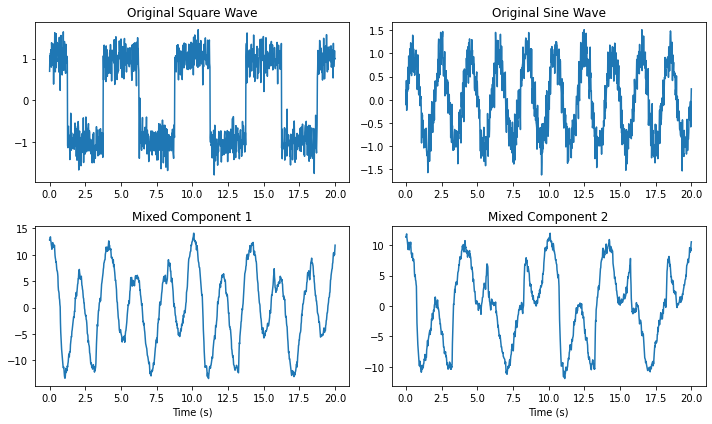

In [249]:
batch_num = 2
plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title('Original Square Wave')
plt.plot(t[batch_num,:], inputs[batch_num, 0,:])

plt.subplot(2, 2, 2)
plt.title('Original Sine Wave')
plt.plot(t[batch_num, :], inputs[batch_num, 1, :])

plt.subplot(2,2,3)
plt.title('Mixed Component 1')
plt.plot(t[batch_num,:], y[batch_num, 0, :].detach().numpy())
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.title('Mixed Component 2')
plt.plot(t[batch_num,:], y[batch_num, 1, :].detach().numpy())
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('time_dept_signal_convolutive_mixing_batch.jpeg')

In [250]:
class ConvolutiveDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same', padding_mode='circular')
        self.conv2 =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same', padding_mode='circular')
        
        self.w = nn.Parameter(torch.rand(2,2), requires_grad=True)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        
        
        samples_out_1 = self.conv1(samples)
        samples_out_2 = self.conv2(samples)
       
        
        return self.w[0,0]*samples_out_1[:,0,:] + self.w[0,1]*samples_out_1[:,1,:], self.w[1,0]*samples_out_2[:,0,:] + self.w[1,1]*samples_out_2[:,1,:]

In [251]:
class ConvolutiveDecoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same', padding_mode='circular')
        self.W = nn.Parameter(torch.rand(2,2), requires_grad=True)
     
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        
        y = self.conv(samples).float()
        z = torch.einsum('ijk, jl -> ilk', [y, self.W.float()])

        return z[:,0,:], z[:,1,:]

In [252]:
class ConvolutiveDecoder3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same')
        self.conv2 =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same')
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        
        
        samples_out_1 = self.conv1(samples)
        samples_out_2 = self.conv2(samples)
       
        
        return samples_out_1[:,0,:] + samples_out_1[:,1,:], samples_out_2[:,0,:] + samples_out_2[:,1,:]

In [253]:
def signal_clarity(sources, inputs):
    r = np.corrcoef(sources, inputs)
    c = np.absolute(np.diff(np.absolute(r), axis=0))
    return np.mean(c)

In [254]:
def train_model(data, lr, batch_size, num_epochs, schedule):
    sample_dim = 1000
    hidden_size = 50
    kernel_length = 50
    #sample_dim = 2000 - 4*kernel_length
    
    mi_est_values = []
    clarity_est = []
    
    decoder = ConvolutiveDecoder2().to(dev)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
    
    mi_estimator = CLUBSample(sample_dim, sample_dim, hidden_size).to(dev)
    mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)
    
    if schedule is True:
        decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)

    data_set = TensorDataset(data[:, 0, :], data[:, 1, :])
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True) 

    for epoch in trange(num_epochs):
        for x_samples, y_samples in data_loader:
            x_samples = torch.div(x_samples, torch.std(x_samples))
            y_samples = torch.div(y_samples, torch.std(y_samples))
            #print('X_samples: ', x_samples.size())
            
            if epoch%5==0:
                x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
                x_samples_out = torch.div(x_samples_out, torch.std(x_samples_out))
                y_samples_out = torch.div(y_samples_out, torch.std(y_samples_out))
                #print('x_samples_out: ', x_samples_out.size())
                
                #x_samples_out_tmp = x_samples_out[:, 2*kernel_length:-2*kernel_length]
                #y_samples_out_tmp = y_samples_out[:, 2*kernel_length:-2*kernel_length]
                
                decoder_loss = mi_estimator(x_samples_out, y_samples_out)
                decoder_optimizer.zero_grad()
                decoder_loss.backward(retain_graph=True)
                #plot_grad_flow(decoder.named_parameters())
                #mi_est_values.append(decoder_loss.cpu().detach().numpy())
                decoder_optimizer.step()
                
                


            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())
            x_samples_out = torch.div(x_samples_out, torch.std(x_samples_out))
            y_samples_out = torch.div(y_samples_out, torch.std(y_samples_out))
            #x_samples_out_tmp = x_samples_out[:, 2*kernel_length:-2*kernel_length]
            #y_samples_out_tmp = y_samples_out[:, 2*kernel_length:-2*kernel_length]
            
            mi_loss = mi_estimator.learning_loss(x_samples_out.detach(), y_samples_out.detach())
            mi_optimizer.zero_grad()
            mi_loss.backward()
            mi_optimizer.step()

        if epoch%5==0:
            x_samples_out, y_samples_out = decoder(data[:, 0, :].float(), data[:, 1, :].float())
            #print('data:', data.size())
            x_samples_out = torch.div(x_samples_out, torch.std(x_samples_out))
            y_samples_out = torch.div(y_samples_out, torch.std(y_samples_out))
            
            #print('x_samples_out bottom:', x_samples_out.size())
            
            #x_samples_out_tmp = x_samples_out[:, 2*kernel_length:-2*kernel_length]
            #y_samples_out_tmp = y_samples_out[:, 2*kernel_length:-2*kernel_length]
            
            
            mi_est_values.append(mi_estimator(x_samples_out, y_samples_out).cpu().detach().numpy())
            
            recovered = np.vstack((x_samples_out[0,:].cpu().detach().numpy(), y_samples_out[0,:].cpu().detach().numpy()))
            original = inputs[0, :, :].cpu().detach().numpy()
            clarity_est.append(signal_clarity(original, recovered))
            
        if schedule is True: 
            decoder_scheduler.step()
    
    return mi_est_values, clarity_est, x_samples_out.cpu().detach().numpy(), y_samples_out.cpu().detach().numpy(), decoder

In [ ]:
y = y.to(dev)
lr=5e-5
batch_size = 250 # equal to the length of the input
num_epochs = 10000
schedule=False

mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, schedule=schedule)

 32%|███▏      | 3176/10000 [04:43<10:10, 11.19it/s]

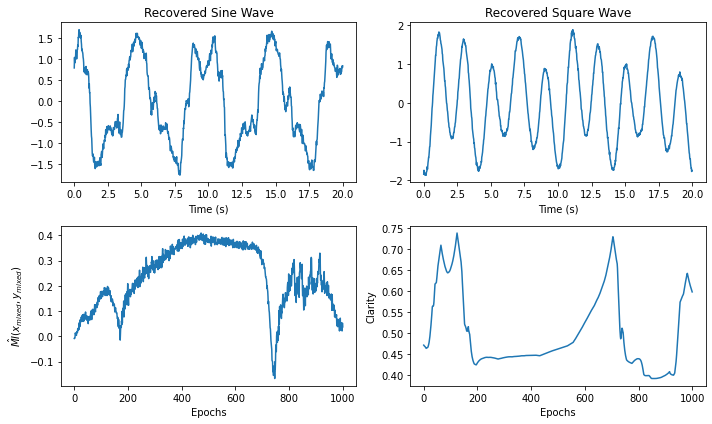

In [276]:
batch_num = 1
#t = t[:, 50:-50]

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t[batch_num, :], x_samples[batch_num, :])

plt.xlabel('Time (s)')

plt.subplot(2, 2, 2)
plt.plot(t[batch_num, :], y_samples[batch_num, :])
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')


plt.subplot(2,2,3)
plt.plot(mi_est_values)
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')


plt.subplot(2,2,4)
plt.plot(clarity_est)
#plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Clarity')
plt.tight_layout()


plt.tight_layout()
plt.savefig('recovered_components_convolution_batch15.jpeg')

In [266]:
inputs.size()

torch.Size([1000, 2, 1000])

In [267]:
kernel_length=50
recovered = np.vstack((x_samples[batch_num,:], y_samples[batch_num,:]))
original = inputs[0,:,:].cpu().detach().numpy()
signal_clarity(original, recovered)

0.5509171104767884

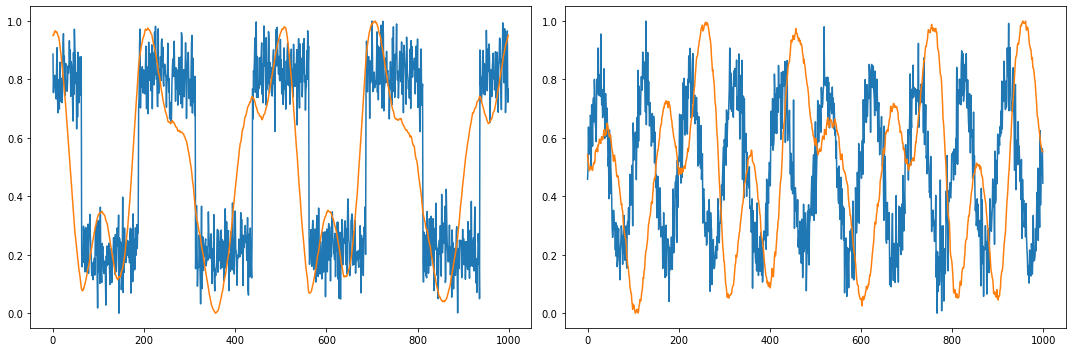

In [274]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot((sklp.minmax_scale(original[0,:])))
plt.plot((sklp.minmax_scale(recovered[0, :])))
plt.subplot(1,2,2)
plt.plot((sklp.minmax_scale(original[1, :])))
plt.plot((sklp.minmax_scale(recovered[1,:])))
plt.tight_layout()
plt.savefig('recovered_components_normed3.jpeg')

In [217]:
np.corrcoef(original[0,:], recovered[1,:])

array([[ 1.        , -0.15957078],
       [-0.15957078,  1.        ]])

In [218]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print (name, param.data)

W tensor([[0.0247, 0.7723],
        [0.0520, 0.4283]], device='cuda:0')
conv.weight tensor([[[ 0.0074, -0.0745, -0.0757,  0.0156,  0.0667,  0.0432,  0.0916,
          -0.0578, -0.1612, -0.0361,  0.0686, -0.0428, -0.0700, -0.0145,
           0.0898,  0.0442, -0.1429, -0.1376, -0.1904,  0.0383, -0.0745,
           0.0667, -0.1183,  0.0602, -0.0228,  0.0311, -0.1842,  0.0805,
          -0.0321,  0.0011,  0.0537,  0.0425, -0.1067,  0.0144, -0.1226,
          -0.1283,  0.0699, -0.1020, -0.0903,  0.0529, -0.0130,  0.0781,
           0.0803, -0.0526,  0.1039,  0.0583, -0.1436, -0.0268, -0.1159,
           0.1048]],

        [[ 0.1445,  0.0576, -0.1107,  0.1548,  0.1082,  0.0868, -0.0865,
           0.0905,  0.0317, -0.0564, -0.0976, -0.1120,  0.0365,  0.0091,
          -0.0378,  0.1114,  0.0185,  0.0245,  0.1340,  0.0097,  0.1333,
           0.0336,  0.0310, -0.1214,  0.0185,  0.0306,  0.0123,  0.0432,
          -0.0222,  0.0578,  0.0515, -0.0790, -0.0890,  0.0379,  0.0776,
          -0.0511,

In [427]:
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.25)
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.25)

square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))

print(inputs.size())
sine2 = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0)
square2 = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0)

square2 = torch.tensor(square2)
sine2 = torch.tensor(sine2)
inputs2 = torch.stack((square2, sine2))

torch.Size([2, 1000, 1000])


In [393]:
signal_clarity(inputs[:,0,:], inputs2[:, 0, :])

0.9777687222015197

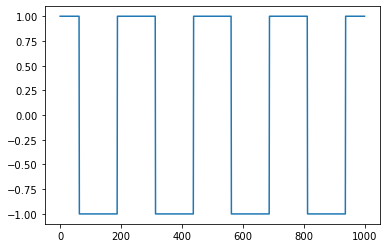

In [394]:
plt.plot(inputs2[0, 0,:])

# Nonlinear encoding

In [ ]:
def sigmoid(x, alpha, beta):
    return 1/(1+torch.exp(-(x-alpha)/beta))

In [ ]:
class ConvolutionSampler_Nonlinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=50, groups=2, bias=False, padding='same', padding_mode='circular')
        
        t = torch.arange(0, 50)
        tau1 = 3
        tau2 = 7
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        self.alpha = nn.Parameter(torch.tensor(0.0, requires_grad=False)
        self.beta = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
            
        self.W = torch.nn.Parameter(torch.tensor([[1.0, 1.5], [1.3, 0.75]], requires_grad = True))

    def forward(self, x):
        y = self.conv(x).double()
        print(y.size())
        z = torch.einsum('ijk, jl -> ilk', [y, self.W.double()])
        z2 = sigmoid(z, self.alpha, self.beta)
        
        return z